In [ ]:
! pip install langchain pillow matplotlib openai

In [6]:
import os
from PIL import Image
import numpy as np

# Images for QA
path = "/Users/rlm/Desktop/Multimodal_Eval/qa/"

# store
img_data_list = []

# Read images and convert them to numpy arrays
for img_file in os.listdir(path):
    if img_file.endswith('.jpeg'):
        img_path = os.path.join(path, img_file)
        with Image.open(img_path) as img:
            img_data_list.append(np.array(img))

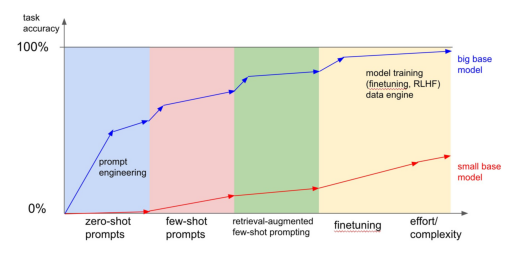

In [7]:
from IPython.display import display
import matplotlib.pyplot as plt

# Get the first image data
first_img_data = img_data_list[0]

# Display the image data using matplotlib
plt.imshow(first_img_data)
plt.axis('off')  # Hide the axis to show only the image
plt.show()

In [ ]:
### Placeholder ### 